In [3]:
# Utility
import numpy as np
import pandas as pd
import pickle

# Plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [7]:
df = pd.read_csv('cyberbullying_tweets.csv')
display(df.sample(5))
df.shape

,tweet_text,cyberbullying_type
23259,Did you see the 1st comment? He is trying to i...,religion
24494,@baileysouthside why did that idiot call the p...,other_cyberbullying
44123,“@TERiYAKi_CHiNK: @YUNGxSMBA fuck you know you...,ethnicity
10625,I'm Jamaican so don't run gay or rape jokes ne...,gender
44378,fuck al sharpton and jesse jackson.. dumb ass ...,ethnicity


(47692, 2)

In [8]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [9]:
for tweet in df.sample(5)['tweet_text']:
    print(tweet +'\n')

@IAmMatticus several pairs. :P

@HuffPostRelig Islam invaded and conquered 2/3 of Christiandom before any Christian crusades in response. The writer is a liar.

Mr Newsom On the "COUNTLESS" scenarios as this, raising taxes 11 billion and people leaving California in droves you better hope that someone is left to vote for loser! Mom attacked by teen girls outside CA high school over bullied daughter https://www.newsbreakapp.com/n/0Nnw4OSA?s=a2&amp;pd=03BFVmgk

I'm a 60 yr old Nana. My last physical altercation was when I was 9, & an 11 yr old bully kept pushing my 7 yr old bro at the school bus stop. 51 years later, I wouldn't be against landing a throat punch on a certain screaming monkey. His neighbors must be saints.

RT @fee_bee_63: Who was responsible for convincing these girls they were so pretty? #MKR



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [11]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,Going to see @TheQuinnspiracy's movie I AM SO ...,religion
freq,2,7998


In [12]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [13]:
df['tweet_text'].duplicated().sum()

1675

In [14]:
df.drop_duplicates('tweet_text', inplace=True, ignore_index=True)
df['tweet_text'].duplicated().sum()

0

In [15]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7937
gender                 7898
other_cyberbullying    6243
Name: count, dtype: int64

In [16]:
df = df[df["cyberbullying_type"] != "other_cyberbullying"]
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity'],
      dtype=object)

In [17]:
cyberbullying_type = ['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity']
encoding_dict = {'not_cyberbullying':0, 'gender':1, 'religion':2, 'age':3, 'ethnicity':4}
df['cyberbullying_type'] = df['cyberbullying_type'].map(encoding_dict)
df.sample(5)

,tweet_text,cyberbullying_type
44246,Must be American RT @futurem0gul: Pissed the f...,4
8688,"imagine thinking 5H say rape, racist &amp; gay...",1
21003,You are not bad people. We Muslims know you ar...,2
21378,After watching previous histories terrorist ar...,2
30796,My middle school bully came into work today,3


In [18]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [19]:
stopwords_list = stopwords.words('english')
additional_stopwords = ['rt', 'mkr', 'didn', 'bc', 'n', 'm', 'im', 'll', 'y', 've', 'u', 'ur', 'don', 't', 's']   # Specific to twitter lingo
stopwords_list.extend(additional_stopwords)
lemmatizer = WordNetLemmatizer()

In [20]:
def remove_usernames(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='@']
    return ' '.join(words)

def remove_hashtags(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[0]!='#']
    return ' '.join(words)

def remove_links(tweet):
    words = tweet.strip().split()
    words = [word for word in words if word[:4]!='http']
    return ' '.join(words)

def remove_punctuation(tweet):
    for mark in punctuation:
        tweet = tweet.replace(mark, '')
    return tweet

def convert_lowercase(tweet):
    return tweet.lower()

def tokenization(tweet):
    return word_tokenize(tweet)

def remove_stopwords(tok_tweet):
    res = []
    for word in tok_tweet:
        if word not in stopwords_list:
            res.append(word)
    return res

def lemmatize_words(tok_tweet):
    res = []
    for word in tok_tweet:
        res.append(lemmatizer.lemmatize(word))
    return res

In [21]:
def pre_processing_custom(tweet):
    tweet = remove_usernames(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_links(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [22]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing_custom)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
12495,These girls are pretty...awful. #gohome #MKR,1,girl prettyawful
43387,"You get no dick RT @tayyoung_: FUCK OBAMA, dum...",4,get dick fuck obama dumb as nigger
40709,"RT @tayyoung_ FUCK OBAMA, dumb ass nigger &lt;...",4,fuck obama dumb as nigger lt ignorance best gu...
40066,That’s so rich coming from a racist like you. ...,4,’ rich coming racist like telling u congresswo...
14748,@Feminazi_Front FUCK YOU!!!,1,fuck


In [23]:
!pip install tweet-preprocessor
import preprocessor as p

In [24]:
def clean_tweets(tweet):
    tweet = p.clean(tweet)
    return tweet

In [25]:
def pre_processing(tweet):
    tweet = clean_tweets(tweet)
    tweet = remove_punctuation(tweet)
    tweet = convert_lowercase(tweet)
    tok_tweet = tokenization(tweet)
    tok_tweet = remove_stopwords(tok_tweet)
    tok_tweet = lemmatize_words(tok_tweet)
    clean_tweet = ' '.join(tok_tweet)

    return clean_tweet

In [26]:
df['clean_tweets'] = df['tweet_text'].map(pre_processing)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets
33682,Bert Velghe and Lennert Acke (both from #Belgi...,3,bert velghe lennert acke owe apology general e...
40782,@pacifictomb Dumb nigger. Xjaws will fuck u up...,4,dumb nigger xjaws fuck fight small dick bitch
43486,"Kanye West called the white girl ""brave"" for ""...",4,kanye west called white girl brave speaking am...
41343,"Neekie, and his holiness is acting like a dumb...",4,neekie holiness acting like dumb fuck idk tryi...
37904,@JOYCE2theworld_ come visit me at school you s...,3,come visit school snitch


In [27]:
df['clean_tweets'].duplicated().sum()

1217

In [28]:
df.drop_duplicates('clean_tweets', inplace=True, ignore_index=True)
df['clean_tweets'].duplicated().sum()

0

In [29]:
df.shape

(38557, 3)

In [30]:
df['word_count'] = df['tweet_text'].map(lambda x: len(x.split()))
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count
10727,You're really skipping over what Sean said whi...,1,youre really skipping sean said massive insult...,51
6509,Pretty sure Vicky and Celine drop out of the c...,0,pretty sure vicky celine drop comp entirely,12
8618,Hypocrisy of you Misha minions is on another l...,1,hypocrisy misha minion another level misha mad...,47
4585,@Coke_N_Smile YOU'RE fantastic! lol he calls b...,0,youre fantastic lol call back call loser,13
14636,Defend “her”...our great nation is a woman whi...,1,defend herour great nation woman chastise cong...,40


In [31]:
def avg_word_length(tweet):
    words = tweet.split()
    word_count = len(words)
    word_length = 0
    for word in words:
        word_length += len(word)
    avg_length = round(word_length / word_count,2)
    return avg_length

df['avg_word_length'] = df['tweet_text'].map(avg_word_length)
df.sample(5)

,tweet_text,cyberbullying_type,clean_tweets,word_count,avg_word_length
17284,Not sure what you’re implying. I’m not a “left...,2,sure youre implying leftist conservative chris...,46,4.78
30110,the girl who abused me knew me because she use...,3,girl abused knew used bully school fucking slu...,48,4.65
11232,RT @BoleynButtz: I believe in equal rights the...,1,believe equal right sexist woman reaction time...,25,4.80
10334,I only watched the 1st one but it wasn't good ...,1,watched st one wasnt good recycled gay rape tr...,23,3.83
16867,"In a major turn of events, even the Christians...",2,major turn event even christian didnt want ass...,30,4.87


In [32]:
df = df[df['word_count']>3]
df = df[df['word_count']<100]
df.reset_index(drop=True, inplace=True)
df.shape

(38201, 5)

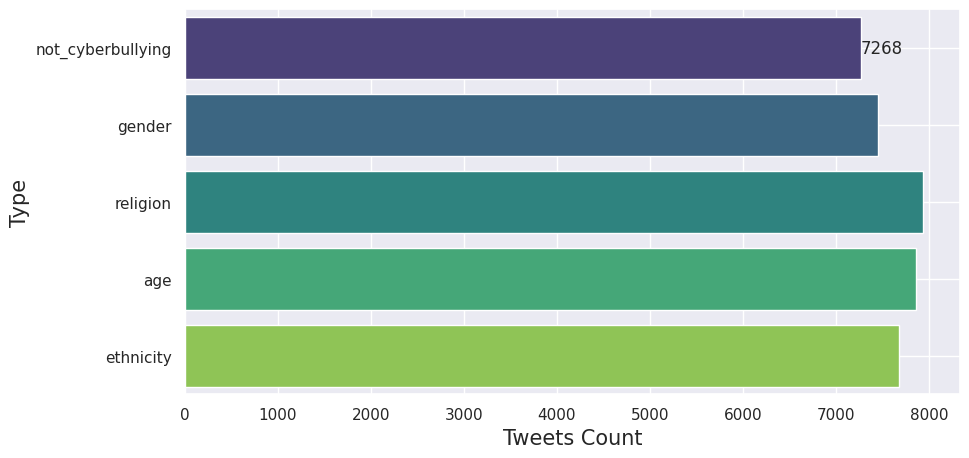

In [33]:
sns.set_theme()
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, y='cyberbullying_type', palette="viridis")
ax.bar_label(ax.containers[0])
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Tweets Count', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

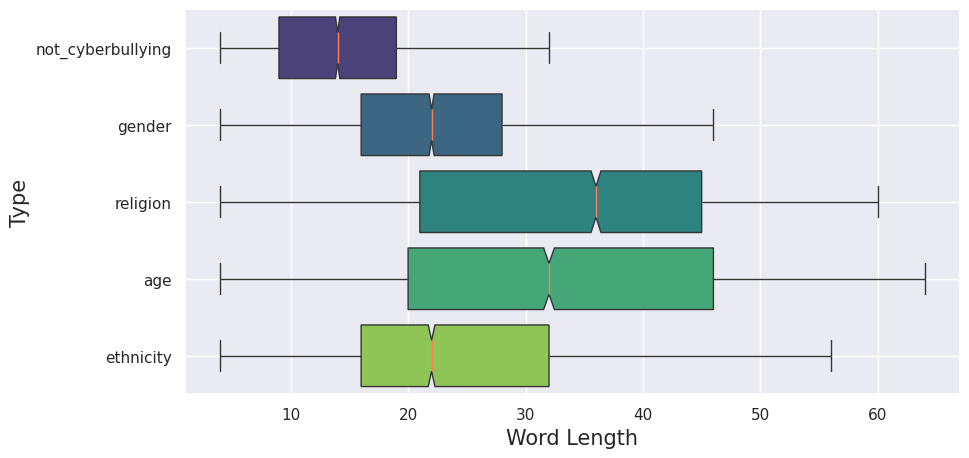

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='cyberbullying_type', x='word_count', orient='h', showfliers=False, palette='viridis', notch=True, medianprops={"color": "coral"})
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Word Length', size=15)
plt.ylabel('Type', size=15)
plt.grid(color='w')

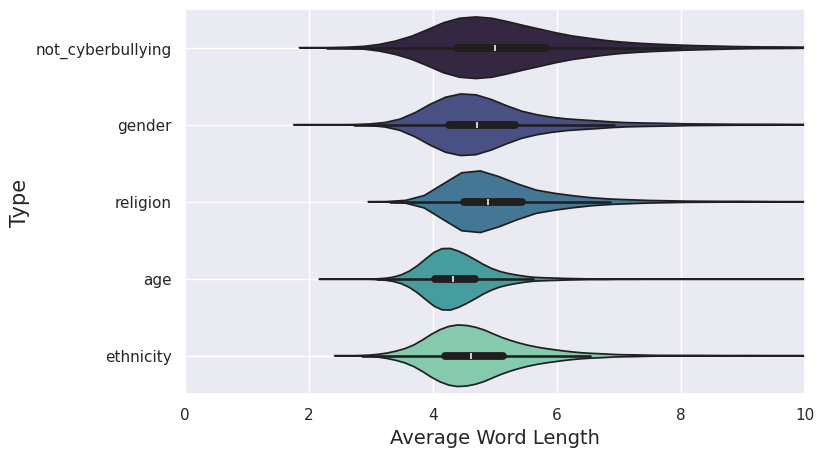

In [35]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, y='cyberbullying_type', x='avg_word_length', orient='h', palette='mako')
plt.xlim(0, 10)
plt.yticks(ticks=[0,1,2,3,4], labels=cyberbullying_type)
plt.xlabel('Average Word Length', size=14)
plt.ylabel('Type', size=15)
plt.grid(color='w')

Text(32.0, 0.5, 'Average Word Length')

<Figure size 800x500 with 0 Axes>

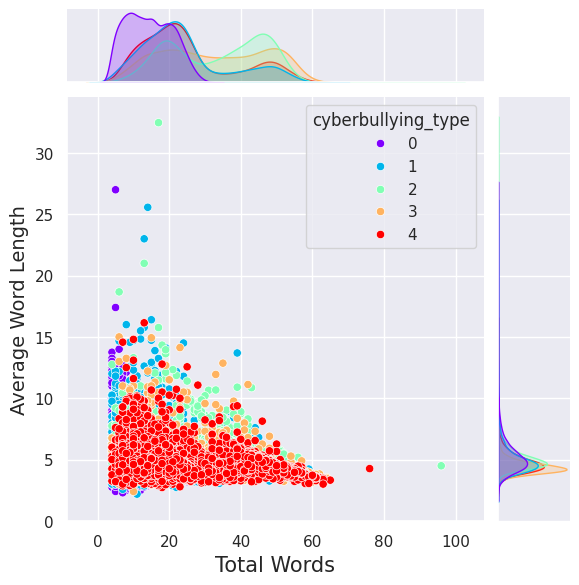

In [36]:
plt.figure(figsize=(8, 5))
sns.jointplot(data=df, y='avg_word_length', x='word_count', hue='cyberbullying_type', palette='rainbow')
plt.xlabel('Total Words', size=15)
plt.ylabel('Average Word Length', size=14)

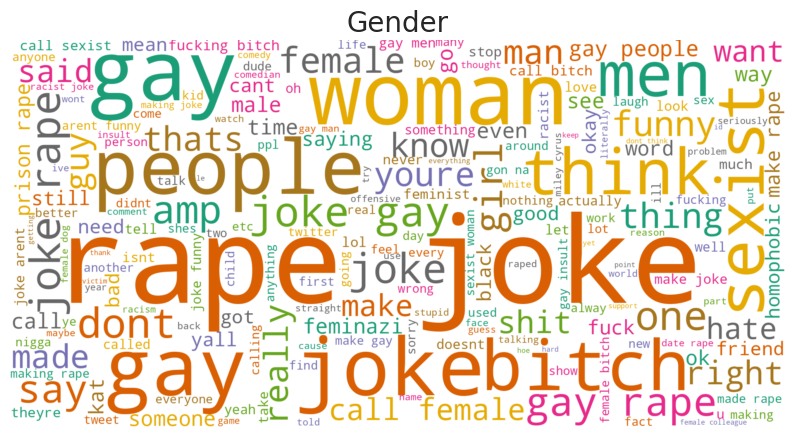

In [37]:
#Gender
plt.figure(figsize=(10, 10))
subset1 = df[df['cyberbullying_type']==1]
text_gender = subset1['clean_tweets'].values
wc1 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_gender))

plt.axis('off')
plt.title("Gender", fontsize=20)
plt.imshow(wc1, interpolation='bilinear')

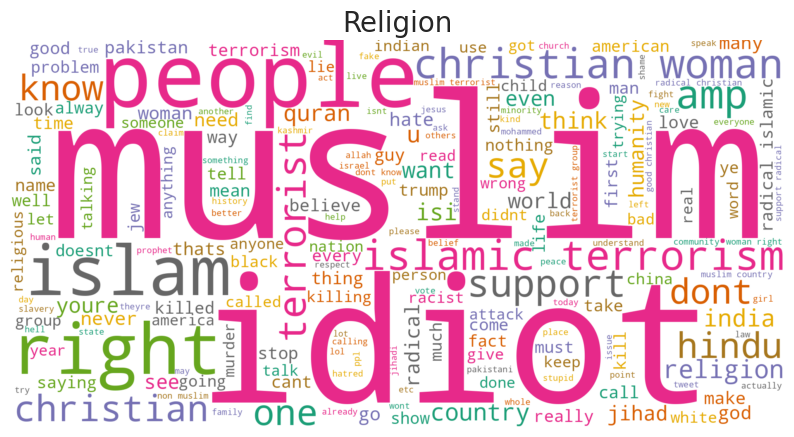

In [38]:
# Religion
plt.figure(figsize=(10, 10))
subset2 = df[df['cyberbullying_type']==2]
text_religion = subset2['clean_tweets'].values
wc2 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_religion))

plt.axis('off')
plt.title("Religion", fontsize=20)
plt.imshow(wc2, interpolation='bilinear')

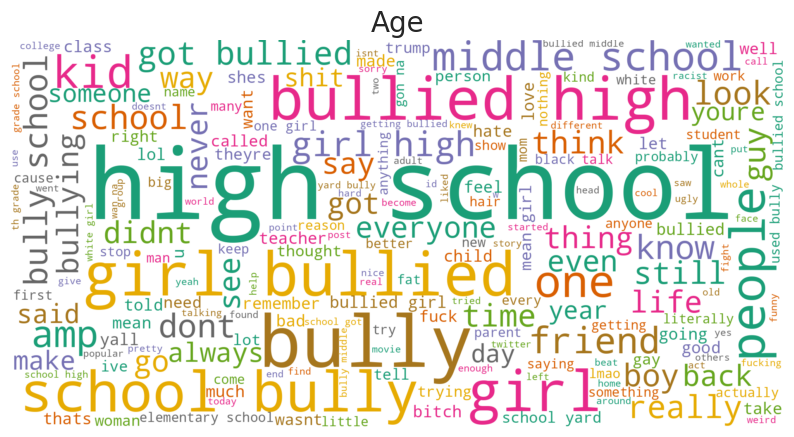

In [39]:
# Age
plt.figure(figsize=(10, 10))
subset3 = df[df['cyberbullying_type']==3]
text_age = subset3['clean_tweets'].values
wc3 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_age))

plt.axis('off')
plt.title("Age", fontsize=20)
plt.imshow(wc3, interpolation='bilinear')

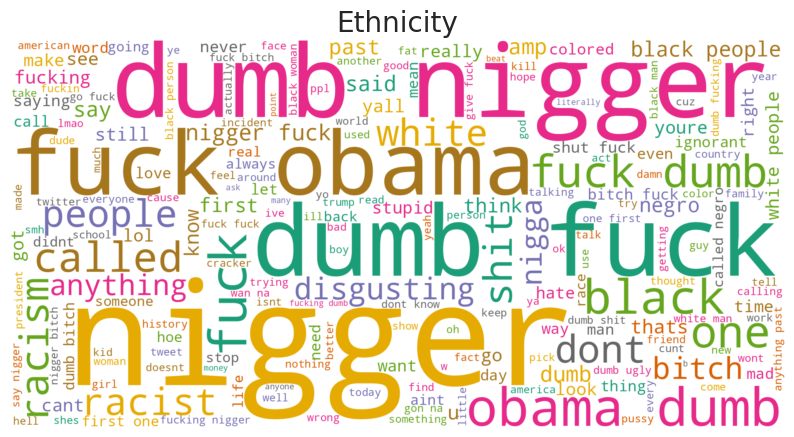

In [40]:
# Ethnicity
plt.figure(figsize=(10, 10))
subset4 = df[df['cyberbullying_type']==4]
text_ethnicity = subset4['clean_tweets'].values
wc4 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_ethnicity))

plt.axis('off')
plt.title("Ethnicity", fontsize=20)
plt.imshow(wc4, interpolation='bilinear')

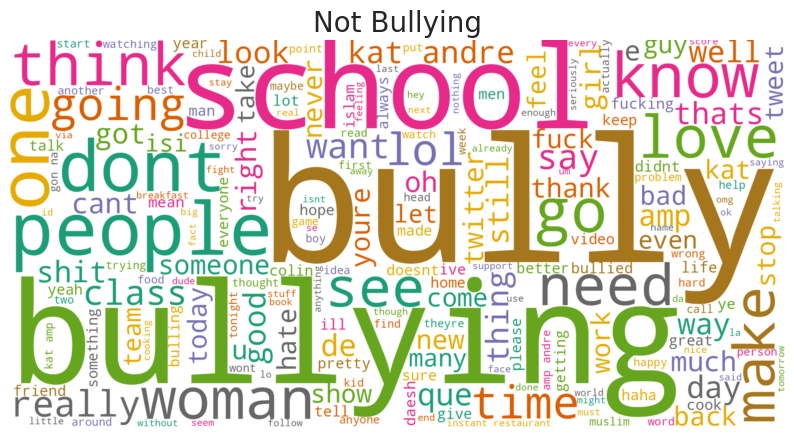

In [41]:
# Not Bullying
plt.figure(figsize=(10, 10))
subset0 = df[df['cyberbullying_type']==0]
text_not = subset0['clean_tweets'].values
wc0 = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_not))

plt.axis('off')
plt.title("Not Bullying", fontsize=20)
plt.imshow(wc0, interpolation='bilinear')

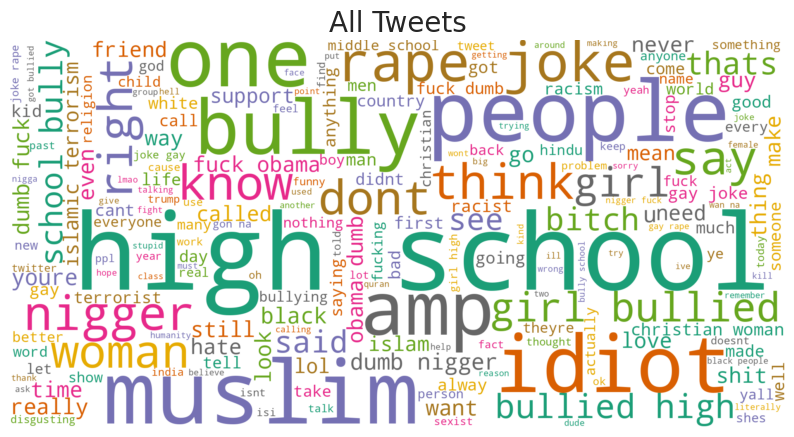

In [42]:
# All Tweets
plt.figure(figsize=(10, 10))
text_all = df['clean_tweets'].values
wc = WordCloud(background_color='white', colormap='Dark2', width=2000, height=1000).generate(' '.join(text_all))

plt.axis('off')
plt.title("All Tweets", fontsize=20)
plt.imshow(wc, interpolation='bilinear')

In [43]:
from collections import Counter   # To count the frequency of each word

temp=[]
for tweet in df['clean_tweets']:
  for word in tweet.split():
    temp.append(word)
vocab = Counter(temp)
print("Vocabulary Size:", len(vocab))
print(list(vocab.items())[:5])

Vocabulary Size: 38438
[('word', 867), ('food', 128), ('crapilicious', 1), ('white', 2213), ('classy', 29)]


In [44]:
common_word=[]
freq=[]
for i, j in vocab.most_common()[:10]:
  common_word.append(i)
  freq.append(j)

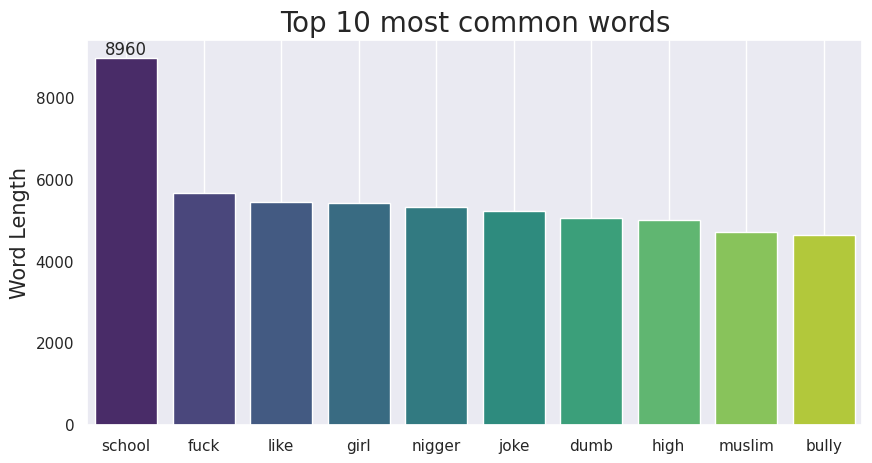

In [45]:
# Most common words
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=common_word, y=freq, palette='viridis')
plt.title('Top 10 most common words', size=20)
ax.bar_label(ax.containers[0])
plt.ylabel("Word Length", size=15)
plt.grid()

In [46]:
X = df['clean_tweets']
y = df['cyberbullying_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=76)

In [47]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)    # Fit on train
print("No. of feature words:", len(tfidf.get_feature_names_out()))

No. of feature words: 291885


In [48]:
X_train_tf = tfidf.transform(X_train)
X_test_tf = tfidf.transform(X_test)
print(f"{X_train_tf.shape = }\n{X_test_tf.shape = }")

X_train_tf.shape = (30560, 291885)
X_test_tf.shape = (7641, 291885)


In [49]:
# Model training
lr = LogisticRegression(solver='saga', penalty='l2', random_state=394)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=394, solver='saga')

In [50]:
# Model prediction
y_pred_train = lr.predict(X_train_tf)
y_pred_test = lr.predict(X_test_tf)

In [51]:
# Model evaluation
print('\tClassification Report for Logistic Regression on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Logistic Regression on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Logistic Regression on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.95      0.91      5814
           gender       0.98      0.91      0.94      5958
         religion       0.98      0.98      0.98      6350
              age       0.98      0.99      0.98      6292
        ethnicity       0.99      0.99      0.99      6146

         accuracy                           0.96     30560
        macro avg       0.96      0.96      0.96     30560
     weighted avg       0.96      0.96      0.96     30560


	Classification Report for Logistic Regression on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.81      0.79      0.80      1454
           gender       0.93      0.85      0.89      1490
         religion       0.95      0.96      0.95      1587
              age       0.92      0.99      0.95      1573
        ethnicity       0.96      0.99      0.97      

Text(0.5, 1.0, 'Confusion Matrix LR')

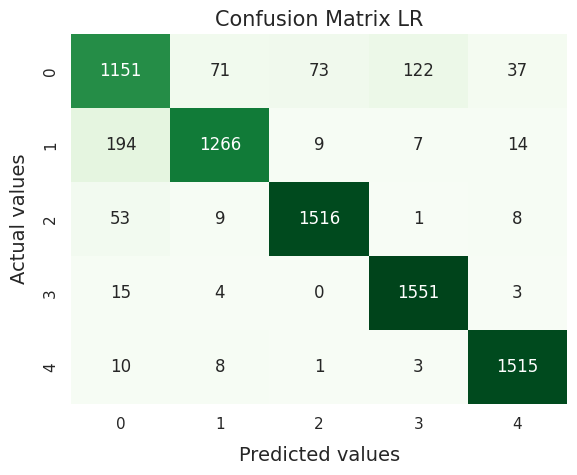

In [52]:
# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix LR', size=15)

In [53]:
# Model training
mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.1)

In [54]:
# Model prediction
y_pred_train = mnb.predict(X_train_tf)
y_pred_test = mnb.predict(X_test_tf)

In [55]:
# Model evaluation
print('\tClassification Report for Naive-Bayes\' on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Naive-Bayes\' on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Naive-Bayes' on Train

                    precision    recall  f1-score   support

not_cyberbullying       1.00      0.97      0.99      5814
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      0.99      6292
        ethnicity       0.99      1.00      1.00      6146

         accuracy                           0.99     30560
        macro avg       0.99      0.99      0.99     30560
     weighted avg       0.99      0.99      0.99     30560


	Classification Report for Naive-Bayes' on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.88      0.48      0.62      1454
           gender       0.87      0.84      0.86      1490
         religion       0.84      0.97      0.90      1587
              age       0.79      0.98      0.88      1573
        ethnicity       0.88      0.94      0.91      1537

        

Text(0.5, 1.0, 'Confusion Matrix NB')

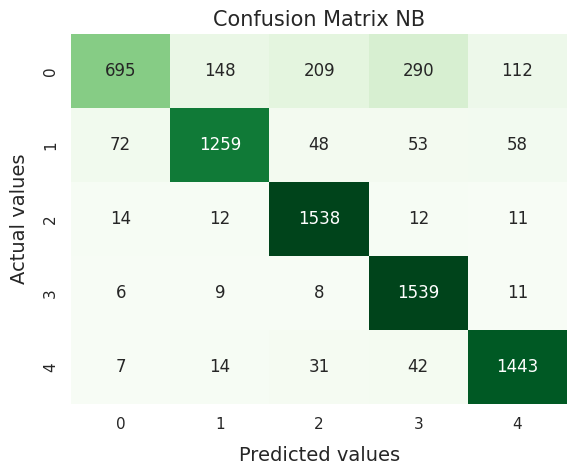

In [56]:
# Confusion Matrix for Naive-Bayes'
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix NB', size=15)

In [57]:
# Model training
rf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, random_state=27)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, random_state=27)

In [58]:
# Model prediction
y_pred_train = rf.predict(X_train_tf)
y_pred_test = rf.predict(X_test_tf)

In [59]:
# Model evaluation
print('\tClassification Report for Random Forest on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Random Forest on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Random Forest on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.77      0.87      0.82      5814
           gender       0.98      0.77      0.86      5958
         religion       0.94      0.96      0.95      6350
              age       0.93      0.98      0.96      6292
        ethnicity       0.98      0.98      0.98      6146

         accuracy                           0.92     30560
        macro avg       0.92      0.91      0.91     30560
     weighted avg       0.92      0.92      0.91     30560


	Classification Report for Random Forest on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.75      0.82      0.78      1454
           gender       0.96      0.75      0.85      1490
         religion       0.91      0.95      0.93      1587
              age       0.91      0.98      0.94      1573
        ethnicity       0.96      0.97      0.97      1537

      

Text(0.5, 1.0, 'Confusion Matrix RF')

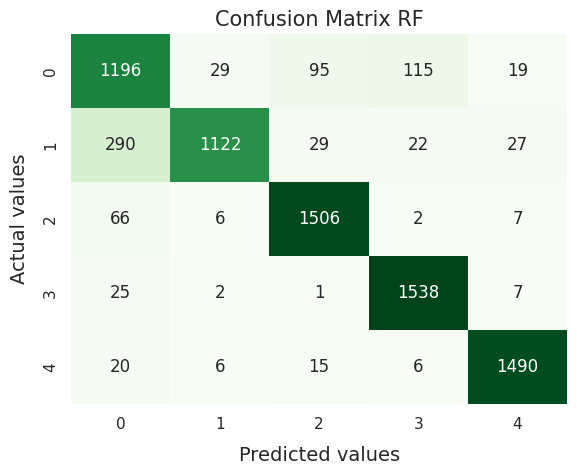

In [60]:
# Confusion Matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix RF', size=15)

In [61]:
# Model Training
from sklearn.ensemble import VotingClassifier

vot = VotingClassifier(estimators = [('lr', lr), ('mnb', mnb), ('rf', rf)], voting='soft')
vot.fit(X_train_tf, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=394,
                                                 solver='saga')),
                             ('mnb', MultinomialNB(alpha=0.1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=30,
                                                     random_state=27))],
                 voting='soft')

In [62]:
# Model prediction
y_pred_train = vot.predict(X_train_tf)
y_pred_test = vot.predict(X_test_tf)

In [63]:
# Model evaluation
print('\tClassification Report for Voting on Train\n\n', classification_report(y_train, y_pred_train, target_names=cyberbullying_type))
print('\n\tClassification Report for Voting on Test\n\n', classification_report(y_test, y_pred_test, target_names=cyberbullying_type))

	Classification Report for Voting on Train

                    precision    recall  f1-score   support

not_cyberbullying       0.99      0.98      0.98      5814
           gender       1.00      0.99      0.99      5958
         religion       0.99      1.00      0.99      6350
              age       0.99      1.00      1.00      6292
        ethnicity       1.00      1.00      1.00      6146

         accuracy                           0.99     30560
        macro avg       0.99      0.99      0.99     30560
     weighted avg       0.99      0.99      0.99     30560


	Classification Report for Voting on Test

                    precision    recall  f1-score   support

not_cyberbullying       0.86      0.71      0.77      1454
           gender       0.92      0.86      0.89      1490
         religion       0.90      0.98      0.94      1587
              age       0.89      0.99      0.94      1573
        ethnicity       0.95      0.98      0.96      1537

         accuracy   

Text(0.5, 1.0, 'Confusion Matrix Voting')

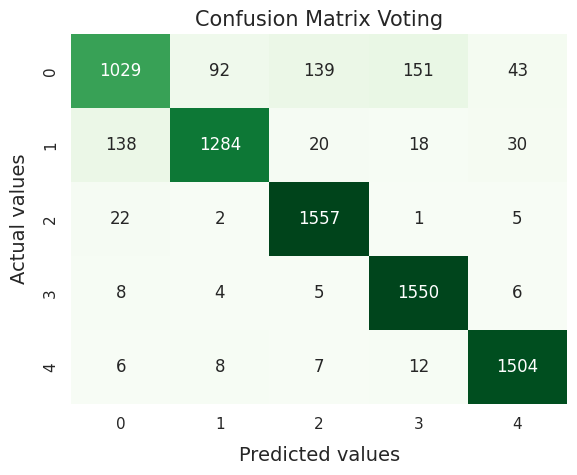

In [64]:
# Confusion Matrix after Voting
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap="Greens", fmt='', cbar=False)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title('Confusion Matrix Voting', size=15)

In [65]:
# Saving Logistic Regression Model
model_file = open('LogisticRegression.pickle','wb')
pickle.dump(lr, model_file)
model_file.close()

# Saving Naive-Bayes' Model
model_file = open('NaiveBayes.pickle','wb')
pickle.dump(mnb, model_file)
model_file.close()

# Saving Random Forest Model
model_file = open('RandomForest.pickle','wb')
pickle.dump(rf, model_file)
model_file.close()

# Saving our final voting aggregated model
model_file = open('Voting.pickle','wb')
pickle.dump(vot, model_file)
model_file.close()

In [66]:
# Defing our custom prediction function
def predict(model, texts):
    clean_texts = [pre_processing_custom(text) for text in texts]
    text_data = tfidf.transform(clean_texts)
    prediction = model.predict(text_data)

    data = []
    for text, prediction in zip(texts, prediction):
        data.append((text, prediction))

    df = pd.DataFrame(data, columns = ['text','type'])
    df = df.replace([0,1,2,3,4], cyberbullying_type)
    return df

In [67]:
# Using our best model
model_file = open('Voting.pickle', 'rb')
model = pickle.load(model_file)
model_file.close()

# Providing some random toxic texts
texts = ["I hate you bitch",
        "School shooting. Haha dead.",
        "Treat them like black slaves",
        "I don't feel so good Mr. Potter",
        "christians are the worst"
        ]

#Our final prediction
predict(model, texts)

,text,type
0,I hate you bitch,gender
1,School shooting. Haha dead.,age
2,Treat them like black slaves,ethnicity
3,I don't feel so good Mr. Potter,not_cyberbullying
4,christians are the worst,religion
